In [277]:
# Load libraries
import os
import numpy as np
import pandas as pd
import tifffile
import json
import PIL
from PIL import Image
from shapely.wkt import loads
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.collections import PatchCollection

%matplotlib inline

In [236]:
# Load grid size data
grid_sizes = pd.read_csv('./Data/grid_sizes.csv', index_col = 0)
first_image_size = grid_sizes.ix['6100_2_3']
first_image_size

Xmax    0.009156
Ymin   -0.009042
Name: 6100_2_3, dtype: float64

In [250]:
tiff_image.shape

(3348, 3391)

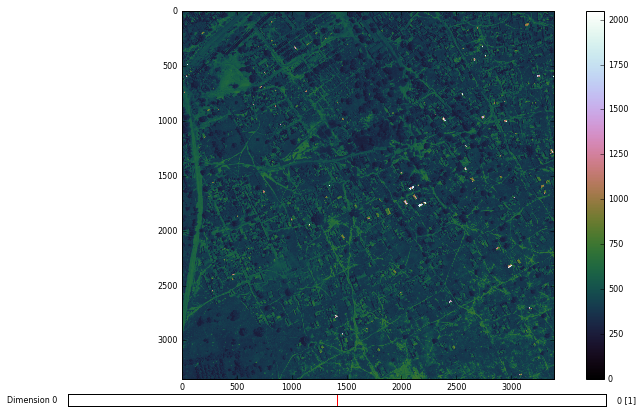

In [315]:
# Read tif file and show image
tiff_image = tifffile.imread('./Data/sixteen_band/6100_2_3_P.tif')
tifffile.imshow(tiff_image)
plt.show()

In [306]:
# Load JSON of tree polygons from image 6120_2_0

poly_image_path = './Data/train_geojson_v3/6100_2_3/001_MM_L3_RESIDENTIAL_BUILDING.geojson'
with open(poly_image_path, 'r') as f:
    poly_image_trees = json.load(f)
    

In [239]:
# x coordinates of polygons
np.array(poly_image_trees['features'][0]['geometry']['coordinates'][0])[:,0]
# y coordinates of polygons
np.array(poly_image_trees['features'][0]['geometry']['coordinates'][0])[:,1]

array([-0.007113 , -0.006525 , -0.005797 , -0.005604 , -0.005186 ,
       -0.004745 , -0.004552 , -0.004501 , -0.004501 , -0.004527 ,
       -0.004648 , -0.005013 , -0.005543 , -0.005602 , -0.005714 ,
       -0.00579  , -0.006671 , -0.00671  , -0.006752 , -0.007031 ,
       -0.007274 , -0.007351 , -0.007504 , -0.007665 , -0.0078   ,
       -0.0081093, -0.007919 , -0.007157 , -0.007113 ])

In [307]:
# Ploygon coordinates from JSON

tree_polygons = []

for i in poly_image_trees['features']:
    tree_polygons.append(np.array(i['geometry']['coordinates'][0]).squeeze())
    

In [241]:
# Convert to polygons

poly_patches = []

for i in tree_polygons:
    poly = matplotlib.patches.Polygon(i)
    poly_patches.append(poly)

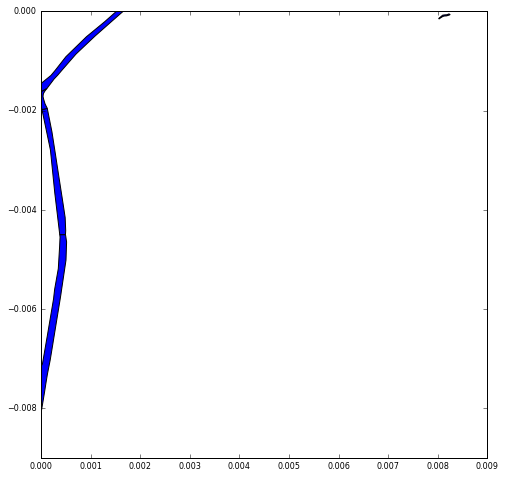

In [242]:
# plot using matplotlib

fig, ax = plt.subplots(figsize=(8, 8))
for polygon in poly_patches:
    ax.add_patch(polygon)
ax.relim()
ax.autoscale_view()

#### How to project geometry to pixel coordinates

In this dataset that we provide, we create a set of geo-coordinates that are in the range of x = [0,1] and y = [-1,0]. These coordinates are transformed such that we obscure the location of where the satellite images are taken from. The images are from the same region on Earth.

To utilize these images, we provide the grid coordinates of each image so you know how to scale them and align them with the images in pixels. In grid_sizes.csv, you are given the Xmax and Ymin values for each imageId. 

For each image, you should be able to get the width (W) and height (H) from the image raster. For a 3-band image that is 3391 x 3349 x 3, W is 3349, and H is 3391. Then you can scale your data as follows:

W′ = W * (W / W + 1)

x′ = (x / xmax) * W′

H′ = H * (H / H + 1)

y′ = (y / ymin) * H′

In [245]:
# Polygon scaling function

def scale_coords(tif_data, image_number, polygon):
    
    width = tif_data.shape[0]
    height = tif_data.shape[1]
    xmax = grid_sizes.ix[image_number]['Xmax']
    ymin = grid_sizes.ix[image_number]['Ymin']
    x = polygon[:,0]
    y = polygon[:,1]
    
    width_scaled = (width**2) / float(width + 1)
    x_scaled = (x / xmax) * width_scaled
    
    height_scaled = (height**2) / float(height + 1)
    y_scaled = (y / ymin) * height_scaled
    
    return np.concatenate([x_scaled[:,None], y_scaled[:,None]], axis=1)

In [328]:
# Scale 'polygons'

scaled_poly = []

for polygon in tree_polygons:
    scaled_poly.append(scale_coords(tiff_image, '6100_2_3', polygon))

In [329]:
# Convert to polygons

poly_patches = []

for i in scaled_poly:
    poly = matplotlib.patches.Polygon(i, color = 'm')
    poly_patches.append(poly)

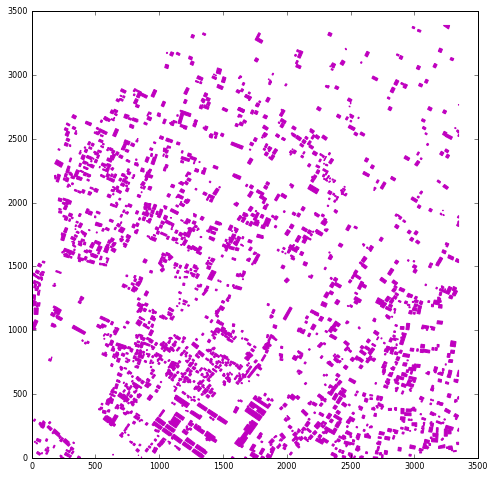

In [318]:
# plot polygon using matplotlib patches

fig, ax = plt.subplots(figsize=(8, 8))
for polygon in poly_patches:
    ax.add_patch(polygon)
ax.relim()
ax.autoscale_view()

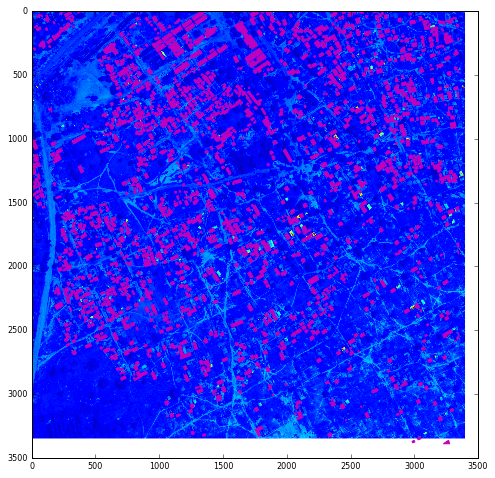

In [322]:
# Overlay polygon

fig, ax = plt.subplots(figsize=(8, 8))
for polygon in poly_patches:
    ax.add_patch(polygon)
ax.imshow(tiff_image)
ax.relim()
ax.autoscale_view()

In [302]:
# Using 3-band images

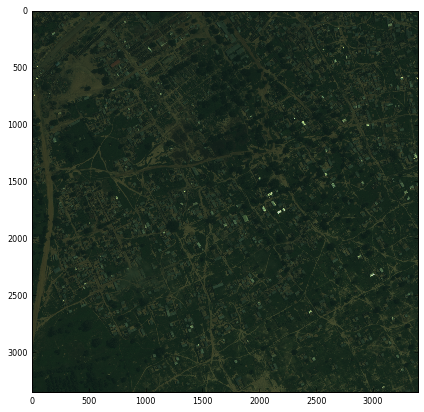

In [323]:
# Read tif file and show image
tiff_image = tifffile.imread('./Data/three_band/6100_2_3.tif').transpose([1,2,0])
tifffile.imshow(tiff_image)
plt.show()

In [324]:
tiff_image.shape

(3349, 3391, 3)

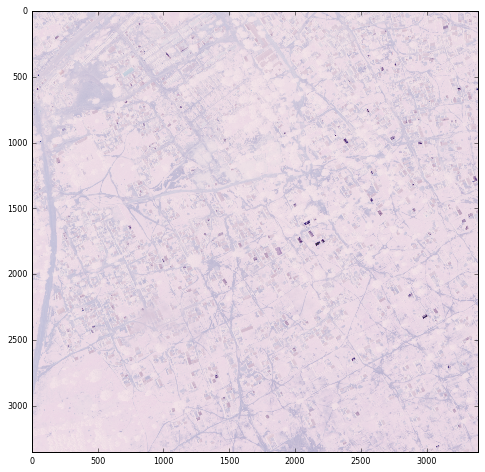

In [325]:
# Non-scaled image

plt.figure(figsize = (8, 8))
plt.imshow(tiff_image)
plt.show()

In [326]:
def scale_percentile(matrix):
    """Fixes the pixel value range to 2%-98% original distribution of values"""
    orig_shape = matrix.shape
    matrix = np.reshape(matrix, [matrix.shape[0]*matrix.shape[1], 3]).astype(float)
    
    # Get 2nd and 98th percentile
    mins = np.percentile(matrix, 1, axis=0)
    maxs = np.percentile(matrix, 99, axis=0) - mins
    
    matrix = (matrix - mins[None,:])/maxs[None,:]
    matrix = np.reshape(matrix, orig_shape)
    matrix = matrix.clip(0,1)
    return matrix

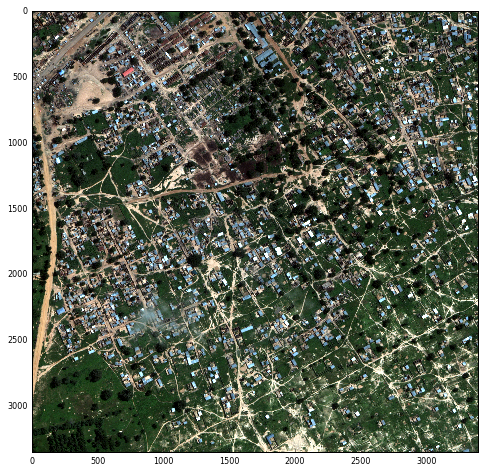

In [327]:
# Scaled image

plt.figure(figsize = (8, 8))
plt.imshow(scale_percentile(tiff_image))
plt.show()

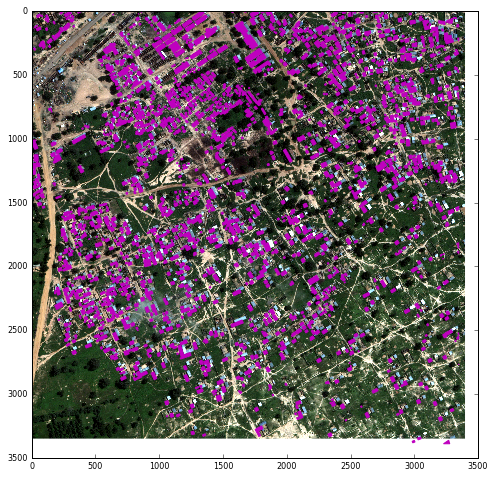

In [330]:
# Overlay polygon to scaled image

fig, ax = plt.subplots(figsize=(8, 8))
for polygon in poly_patches:
    ax.add_patch(polygon)
ax.imshow(scale_percentile(tiff_image))
ax.relim()
ax.autoscale_view()